<h1 style="font-family:Didot;text-align:center;"> Bitcoin Price Forecasting </h1>

In [ ]:
import pandas as pd
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
import pmdarima 
import xgboost as xgb
import matplotlib.dates as mpl_dates
from sklearn.preprocessing import StandardScaler
from mpl_finance import candlestick_ohlc
from prophet import Prophet
from arch import arch_model
from itertools import product

sns.set_style("darkgrid")

In [ ]:
rsme = lambda yhat, y: np.sqrt(np.square(yhat - y).mean())

In [ ]:
df = pd.read_csv("BTC-USD.csv")
df = df[["Date", "Open"]]
df['Date'] = pd.to_datetime(df['Date'])

def split_data(data, train_prop):
    n = int(train_prop * len(data))
    return data[:n], data[n:]

new_df = df[df['Date'] < '2020-10']
train_df, test_df = split_data(new_df, 0.9) 

<h2 style="font-family:Didot;text-align:center;">ARIMA</h2>

In [ ]:
def choose_best_model(data, max_iter=50):
    p, q, d = 0, 0, 1
    i = 1
    current_aic = float("inf")
    model = 'basic'
    new_model = sm.tsa.arima.ARIMA(data, order=(p, d, q)).fit()
    aic = new_model.aic
    while (aic < current_aic) and i < max_iter:
        model = new_model
        current_aic = aic
        p = p + 1 if i % 2 == 1 else p
        q = q + 1 if i % 2 == 0 else q
        try:
            new_model = sm.tsa.arima.ARIMA(data, order=(p, d, q)).fit()
            aic = new_model.aic
            i += 1
        except:
            print(f"wrong params: {p}, {d}, {q}")
            continue
            i += 1
    return model

def choose_best_model_rsme(data, max_p=7, max_q=7):
    possible = list(product(range(1, max_p+1), [1, 2], range(1, max_q+1)))
    current_rsme = float("inf")
    rsmes = []
    for i in possible:
        model = sm.tsa.arima.ARIMA(data, order=(i[0], i[1], i[2])).fit()
        rsmes.append(rsme(invboxcox(model.predict(start=0, end=len(train_df)), lambda_), test_df['Open']))
    return possible[np.nanargmin(rsmes)]

In [ ]:
arima_train = train_df.copy()
arima_train['Open'], lambda_ = stats.boxcox(arima_train['Open']) 
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [ ]:
out_put = choose_best_model_rsme(arima_train['Open'])

/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: 

In [ ]:
rsme_optimal = pmdarima.arima.ARIMA(order=(3, 2, 4)).fit(arima_train['Open'])

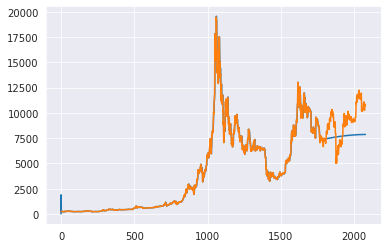

In [ ]:
rsme_optimal_preds = np.concatenate(list(map(lambda x: invboxcox(x, lambda_), [rsme_optimal.predict_in_sample(), rsme_optimal.predict(n_periods=len(test_df))])))
plt.plot(rsme_optimal_preds)
plt.plot(new_df['Open'])

In [ ]:
rsme(rsme_optimal_preds[-len(test_df):], test_df['Open'])

1976.5013492258709

In [ ]:
rsme(rsme_optimal_preds[:len(train_df)], train_df['Open'])

292.66819479522894

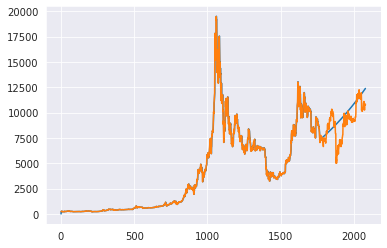

In [ ]:
# using pmdarima
arima_model = pmdarima.auto_arima(arima_train['Open'])
arima_preds = arima_model.predict(n_periods=len(test_df))
arima_preds = np.concatenate(list(map(lambda x: invboxcox(x, lambda_), [arima_model.predict_in_sample(), arima_preds])))
plt.plot(np.arange(1, len(new_df)+1), arima_preds)
plt.plot(np.arange(1, len(new_df)+1), new_df['Open'])
plt.show()

In [ ]:
rsme(arima_preds[:len(train_df)], train_df['Open'])

290.1680019742372

In [ ]:
rsme(arima_preds[-len(test_df):], test_df['Open'])

1360.4837505236692

<h2 style="font-family:Didot;text-align:center;">GARCH + ARIMA</h2>

In [ ]:
def choose_best_model_garch(data, max_iter=50):
    p, q = 1, 1
    i = 1
    current_aic = float("inf")
    model = 'basic'
    new_model = arch_model(data, p=p, q=q, vol='GARCH').fit(disp='off')
    aic = new_model.aic
    while (aic < current_aic) and i < max_iter:
        model = new_model
        current_aic = aic
        p = p + 1 if i % 2 == 1 else p
        q = q + 1 if i % 2 == 0 else q
        try:
            new_model = arch_model(data, p=p,  o=1, q=q, vol='GARCH', dist="StudentsT").fit(disp='off')
            aic = new_model.aic
            i += 1
        except:
            print(f"wrong params: {p}, {q}")
            continue
            i += 1
    return model

<h2 style="font-family:Didot;text-align:center;">LSTM</h2>

In [ ]:
class LSTM(torch.nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        
        super(LSTM, self).__init__()
        self.rnn = torch.nn.LSTM(input_size,hidden_size)
        self.reg = torch.nn.Linear(hidden_size,output_size)

    def forward(self, x):
        x, _ = self.rnn(x) 
        x = self.reg(x)
        return x

In [ ]:
def create_data(data, lag=1, out=1):

    n = len(data)
    scaler = StandardScaler().fit(data.reshape(-1, 1))
    data = np.vstack(scaler.transform(data.reshape(-1, 1)))
    return (scaler,
            torch.from_numpy(np.hstack([data[i:n-lag-out+i+1] for i in range(lag)]).reshape(n-lag-out+1, 1, lag)), 
            torch.from_numpy(np.hstack([data[i+lag:n-out+i+1] for i in range(out)]).reshape(n-lag-out+1, 1, out)))

In [ ]:
lag = 3
h = 10
out = len(test_df)
train = np.array(train_df['Open'].astype(np.float32))
scaler, train_x, train_y = create_data(train, lag, out)
model = LSTM(lag, h, out)

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    output = model(train_x)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    print('Epoch: {:<3}, Loss:{:.6f}'.format(epoch+1, loss.
    item()))

Epoch: 2  , Loss:1.033559
Epoch: 3  , Loss:1.031122
Epoch: 4  , Loss:1.028738
Epoch: 5  , Loss:1.026383
Epoch: 6  , Loss:1.024046
Epoch: 7  , Loss:1.021723
Epoch: 8  , Loss:1.019408
Epoch: 9  , Loss:1.017102
Epoch: 10 , Loss:1.014800
Epoch: 11 , Loss:1.012500
Epoch: 12 , Loss:1.010200
Epoch: 13 , Loss:1.007894
Epoch: 14 , Loss:1.005579
Epoch: 15 , Loss:1.003249
Epoch: 16 , Loss:1.000900
Epoch: 17 , Loss:0.998530
Epoch: 18 , Loss:0.996136
Epoch: 19 , Loss:0.993718
Epoch: 20 , Loss:0.991275
Epoch: 21 , Loss:0.988807
Epoch: 22 , Loss:0.986312
Epoch: 23 , Loss:0.983789
Epoch: 24 , Loss:0.981236
Epoch: 25 , Loss:0.978650
Epoch: 26 , Loss:0.976029
Epoch: 27 , Loss:0.973370
Epoch: 28 , Loss:0.970667
Epoch: 29 , Loss:0.967916
Epoch: 30 , Loss:0.965111
Epoch: 31 , Loss:0.962246
Epoch: 32 , Loss:0.959312
Epoch: 33 , Loss:0.956300
Epoch: 34 , Loss:0.953201
Epoch: 35 , Loss:0.950005
Epoch: 36 , Loss:0.946702
Epoch: 37 , Loss:0.943283
Epoch: 38 , Loss:0.939739
Epoch: 39 , Loss:0.936066
Epoch: 40 , 

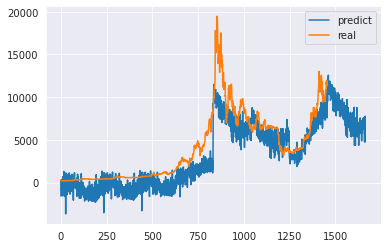

In [ ]:
inputs = [(len(new_df) - lag) % out + out * i for i in range((len(new_df) - lag) // out - 1)]
p = model(train_x)[inputs,0,:].flatten()
plt.plot(scaler.inverse_transform(p.data.numpy().reshape(-1, 1)), label= 'predict')
plt.plot(scaler.inverse_transform(train_y[(len(new_df) - lag) % out:, 0, 0].reshape(-1, 1)), label = 'real')
plt.legend()
plt.show()

In [ ]:
predictions_train = scaler.inverse_transform(p.data.numpy().reshape(-1, 1))

In [ ]:
test = np.array(test_df['Open'].astype(np.float32))
scaler, train_x, train_y = create_data(train, lag, 1)
#scaler, test_x, test_y = create_data(test, lag, out)

In [ ]:
x0 = train_x[-1:, :, :]
p = model(x0)

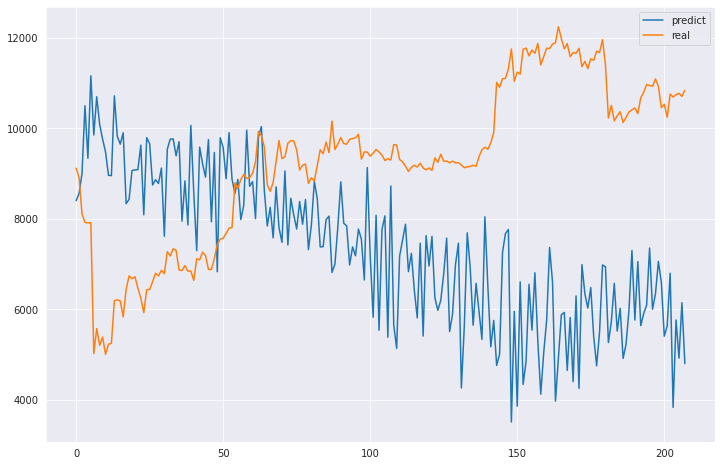

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(p.data.numpy().reshape(-1, 1)), label= 'predict')
plt.plot(test, label = 'real')
plt.legend()
plt.show()

In [ ]:
rsme(scaler.inverse_transform(p.data.numpy().reshape(-1, 1)), test)

2786.453

In [ ]:
predictions_test = scaler.inverse_transform(p.data.numpy().reshape(-1, 1))

In [ ]:
df_results['LSTM'] = np.hstack((np.array([np.nan] * (lag + (len(new_df) - lag) % out)), np.vstack((predictions_train, predictions_test)).flatten()))
df_results.to_csv("results.csv", index=False)

<h2 style="font-family:Didot;text-align:center;">Prophet</h2>

In [ ]:
prophet_train = train_df.copy()
prophet_train.columns = ['ds', 'y']

In [ ]:
model_p = Prophet(changepoint_prior_scale=0.25, daily_seasonality=True)
model_p.fit(prophet_train)

In [ ]:
future = model_p.make_future_dataframe(periods=len(test_df))
forecast = model_p.predict(future)

In [ ]:
training_rsme = rsme(forecast['yhat'][:len(train_df)], train_df['Open'])
training_rsme

659.9568271695963

In [ ]:
test_rsme = rsme(forecast['yhat'][len(train_df):], test_df['Open'])
test_rsme

2775.2116064157444

In [ ]:
df_results = pd.DataFrame({"FBProphet": fb_preds})

<h2 style="font-family:Didot;text-align:center;">XGBoost</h2>

In [ ]:
def create_features(df, label=None):
    new_df = df.copy()
    new_df['dayofweek'] = df['Date'].dt.dayofweek
    new_df['quarter'] = df['Date'].dt.quarter
    new_df['month'] = df['Date'].dt.month
    new_df['year'] = df['Date'].dt.year
    new_df['dayofyear'] = df['Date'].dt.dayofyear
    new_df['dayofmonth'] = df['Date'].dt.day
    new_df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = new_df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = new_df[label]
        return X, y
    return X

In [ ]:
xgb_train, y_train = create_features(train_df, label='Open')
xgb_test, y_test = create_features(test_df, label='Open')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


In [ ]:
xgb_reg = xgb.XGBRegressor(n_estimators=350)
xgb_reg.fit(xgb_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=350, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
whole_X, whole_y = create_features(new_df, 'Open')
xgb_training = rsme(xgb_reg.predict(xgb_train), whole_y[0:len(train_df)])
xgb_testing = rsme(xgb_reg.predict(xgb_test), whole_y[len(train_df):])
xgb_training, xgb_testing

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


(8.160568996936814, 3042.5010668050872)

In [ ]:
preds_x = xgb_reg.predict(whole_X)

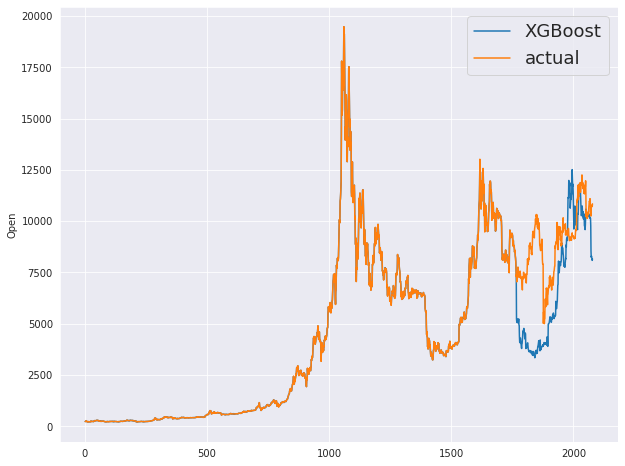

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

xs = np.arange(1, len(new_df)+1)
sns.lineplot(x=xs, y=preds_x)
sns.lineplot(x=xs, y=whole_y)
plt.legend(["XGBoost", "actual"], fontsize=18)
plt.show()

<h2 style="text-align:center;font-family:Didot;">Final plot</h2>

In [ ]:
results = pd.read_csv('results.csv', index_col=False)
results = results.drop(columns='Unnamed: 0')
results['Date'] = new_df['Date']

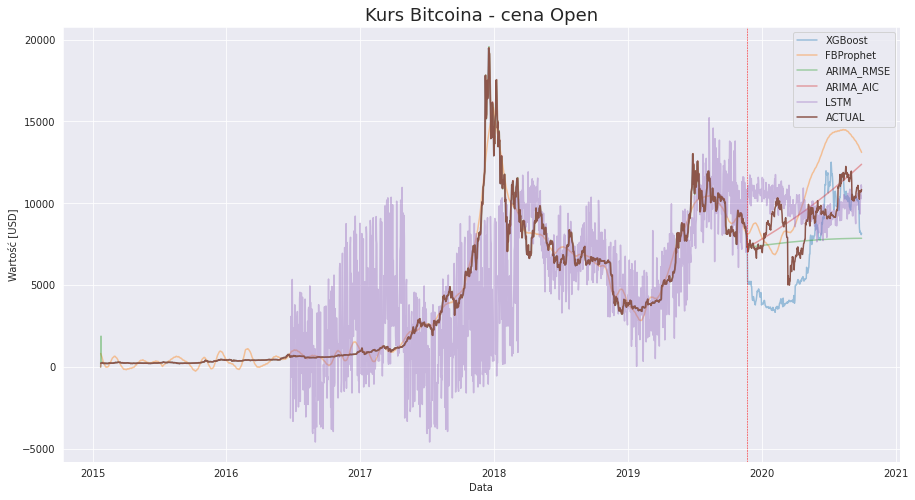

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x='Date', y='XGBoost', data=results, alpha=.4, ax=ax)
sns.lineplot(x='Date', y='FBProphet', data=results, alpha=.4, ax=ax)
sns.lineplot(x='Date', y='Arima_rsme_optimal', data=results, alpha=.4, ax=ax)
sns.lineplot(x='Date', y='arima_AIC', data=results, alpha=.4, ax=ax)
sns.lineplot(x='Date', y='LSTM', data=results, alpha=.4, ax=ax)
sns.lineplot(x='Date', y='Actual', data=results, alpha=1, ax=ax) 
plt.legend(['XGBoost', 'FBProphet', 'ARIMA_RMSE', 'ARIMA_AIC', 'LSTM', 'ACTUAL'])
plt.xlabel('Data')
plt.ylabel('Wartość [USD]')
plt.title('Kurs Bitcoina - cena Open', fontsize=18)
plt.axvline(x=results['Date'][1765], linestyle='--', color="red", linewidth=.5)
plt.savefig('wykres.svg')
plt.show()

In [ ]:
data = pd.read_csv("monthly_bit.csv", index_col=False)
ohlc = data.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

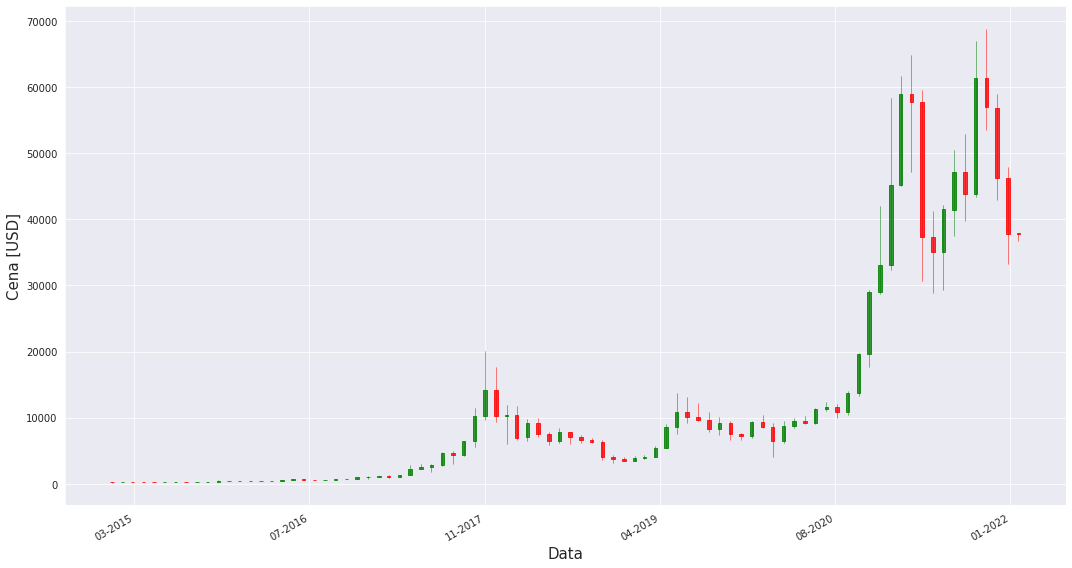

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

candlestick_ohlc(ax, ohlc.values, width=10, colorup='green', colordown='red', alpha=0.8)

ax.set_xlabel('Data', fontsize=15)
ax.set_ylabel('Cena [USD]', fontsize=15)

date_format = mpl_dates.DateFormatter('%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
plt.savefig("candlestick.svg")

fig.tight_layout()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=377bb9ed-d945-4dac-afc1-629c5df3eca9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>